<a href="https://colab.research.google.com/github/HwangJae-won/Data_project_practice/blob/main/1019_california_housing_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up & Load Data

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
from sklearn.datasets import fetch_california_housing
data= fetch_california_housing(as_frame = True)

In [120]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [121]:
#데이터 생성
feature= pd.DataFrame(data.data)
feature.columns = data.feature_names

target = pd.DataFrame(data.target)
target.columns=data.target_names

In [122]:
df = pd.concat([feature, target],axis= 1)
df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


# EDA & Data Processing

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


결측치는 없고, numerical feature로만 이루어져 있으므로 다양한 변수 생성, PCA를 활용한 변수 선택 등 연습해보자

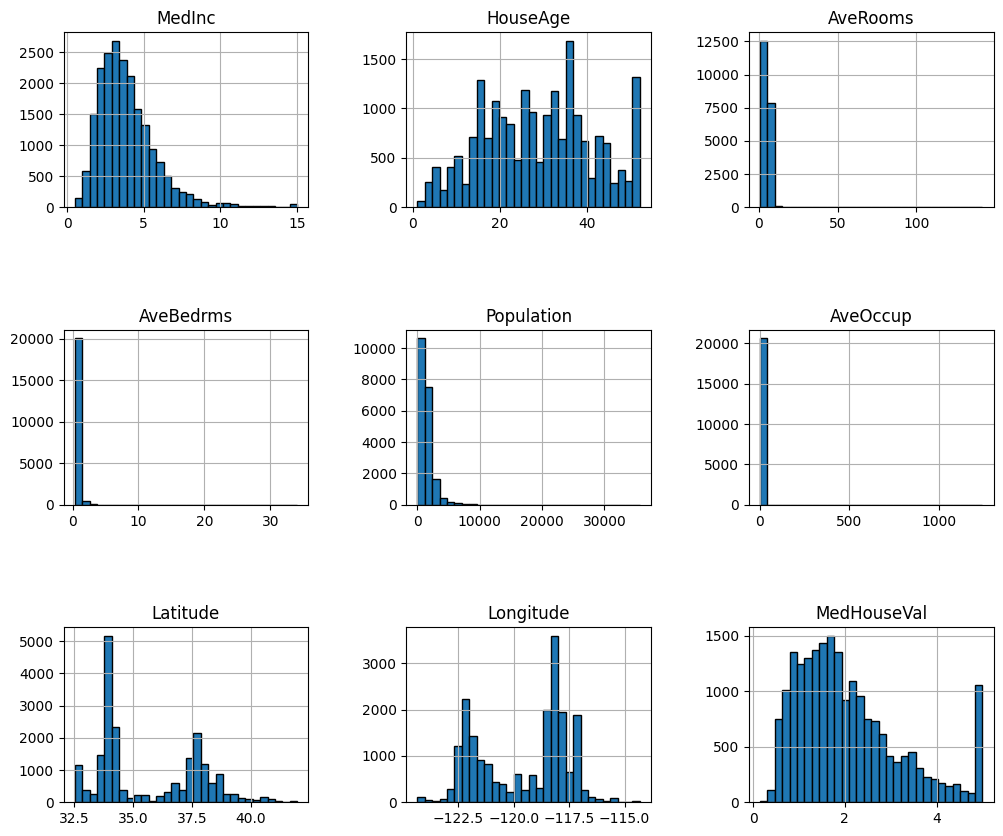

In [78]:
#변수들의 분포 확인
df.hist(figsize= (12,10), bins = 30, edgecolor = "black")
plt.subplots_adjust(hspace =0.7, wspace = 0.4)

'AveRooms', 'AveBedrms', 'Population', 'AveOccup' 변수는 굉장히 skewed함

<Axes: >

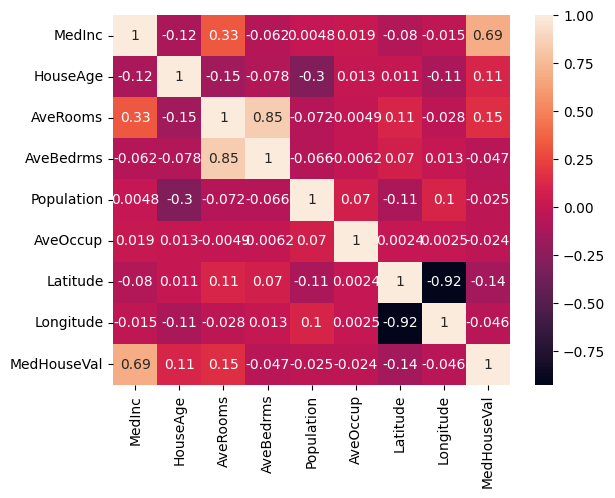

In [96]:
corr= df.corr()
sns.heatmap(corr, annot = True)

In [104]:
abs(corr["MedHouseVal"]).sort_values()

AveOccup       0.023737
Population     0.024650
Longitude      0.045967
AveBedrms      0.046701
HouseAge       0.105623
Latitude       0.144160
AveRooms       0.151948
MedInc         0.688075
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64

큰 상관 관계를 보이는 변수는 존재하지 않음

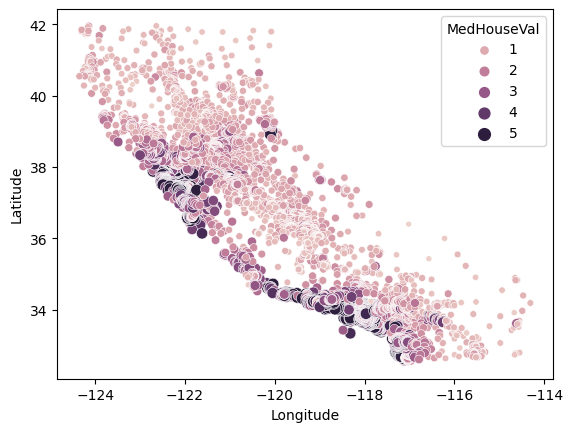

In [107]:
#위도 경도는 확인 : 위치에 따라 y의 분포가 다름
sns.scatterplot(
    data=df,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal"
) #크기와 색상 별로 위도 경도 시각화
plt.show()

위치별로 소득 수준이 분명 다름을 확인할 수 있음

[로그 변환 vs  scaling]
- 개별 feature 또는 target 분포도가 skew가 심하면 log transformation
- standard scaler는 일반적으로 전체 feature들에 다 적용 시킴(전체 데이터의 스케일링을 맞추고 싶을 때 !)

In [124]:
log_list = ['AveRooms', 'AveBedrms', 'Population', 'AveOccup']

In [125]:
#위경도 변수 제외 나머지 X 변수에 대해서는 로그 변환
for i in log_list:
  df[i] = np.log1p(df[i])

#feature Engineering

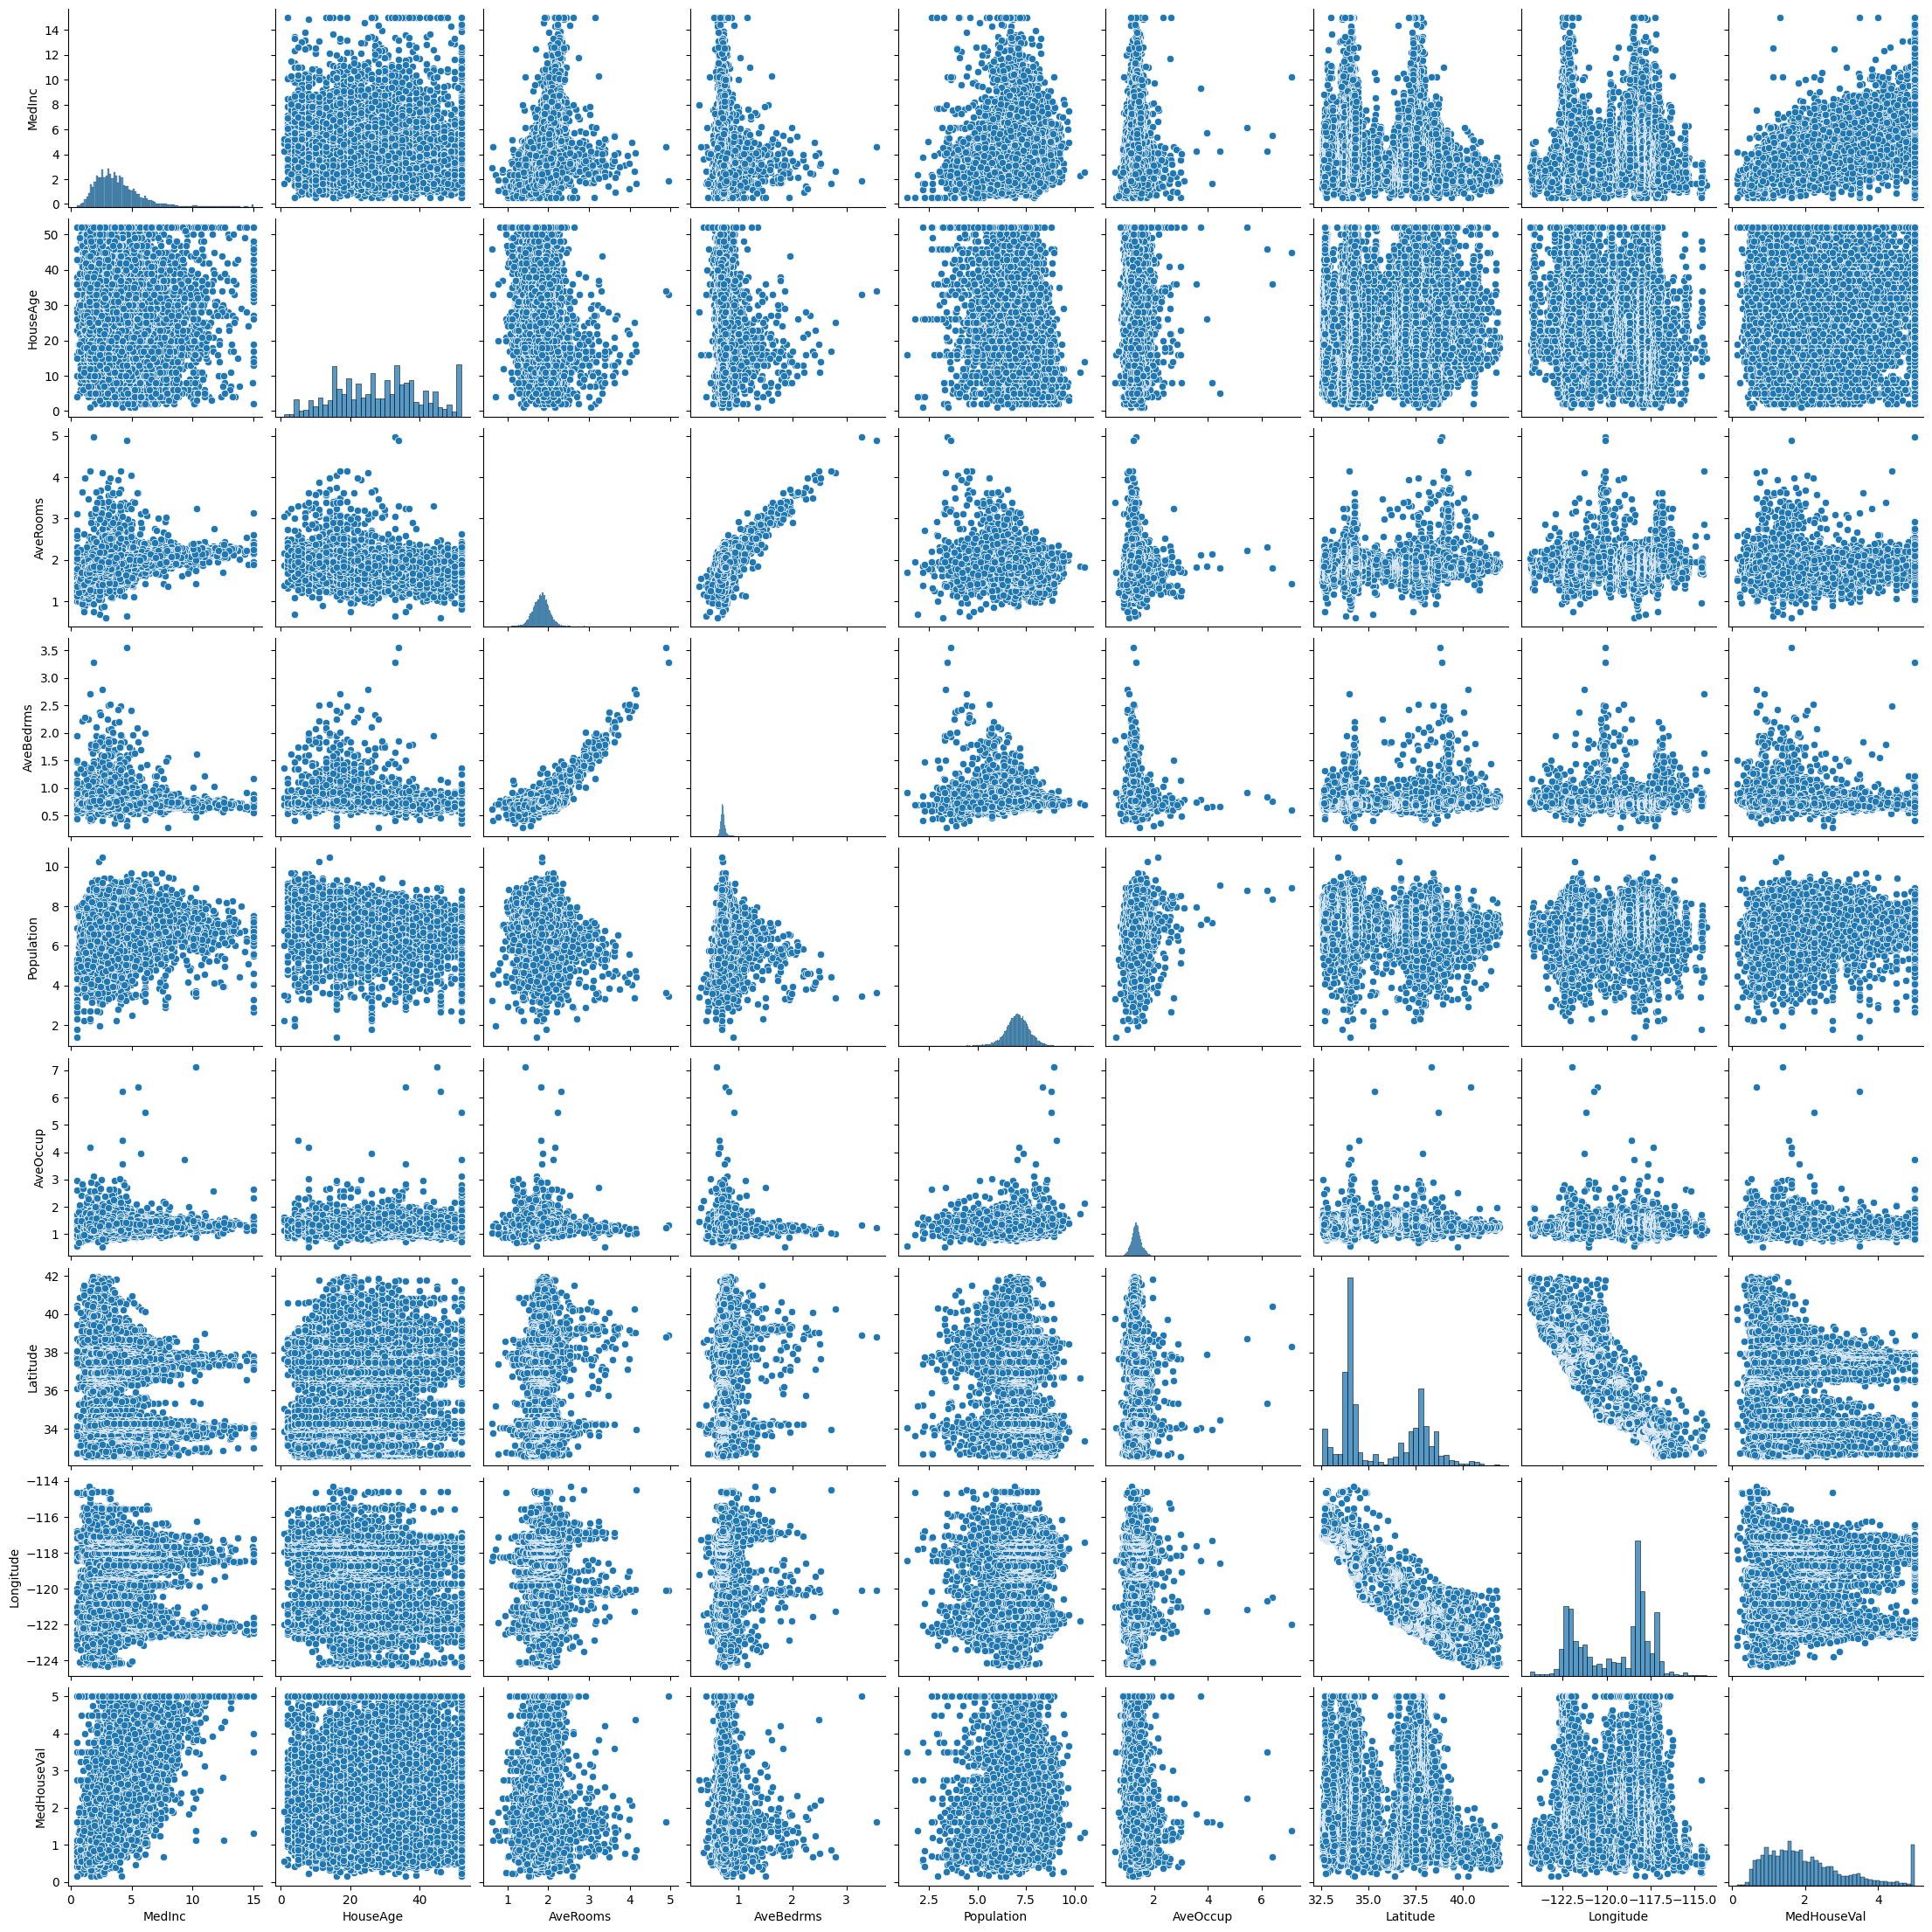

In [116]:
#기존 변수들과 y 변수와의 선형 관계 확인
sns.pairplot(df)

선형 관계 확인 어려움

In [126]:
#방 개수 + 침실 개수 :avgroom 변수 생성
df["room"] = df.AveRooms + df.AveBedrms

위도 경도 데이터로 Kmeans 클러스터링 : 클러스터링 결과를 feature로 활용해보고자 함

In [139]:
X= df.iloc[:,6:8]

In [131]:
from sklearn.cluster import KMeans

In [140]:
X = np.array(X)
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters= i, init ='k-means++', max_iter = 300, n_init =1, random_state= 42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

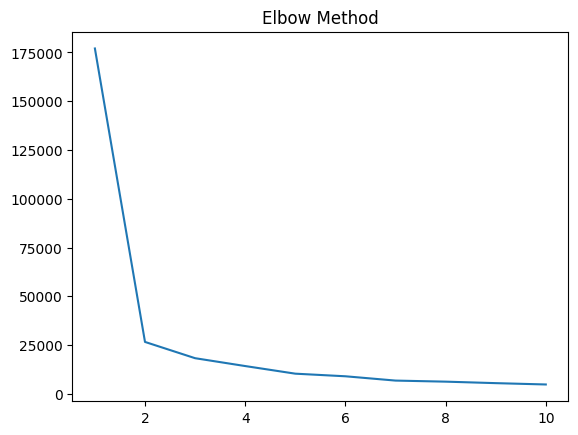

In [141]:
plt.plot(range(1,11), wcss)
plt.title("Elbow Method")
plt.show()

In [144]:
kmeans =KMeans(n_clusters= 5, init ='k-means++', max_iter = 300, n_init =1, random_state= 42)

In [145]:
kmeans.fit(X)

KMeans(n_clusters=5, n_init=1, random_state=42)

In [146]:
print(kmeans.labels_)

[0 0 0 ... 4 4 4]


In [147]:
len(kmeans.labels_)

20640

In [159]:
df["kmeans"]= kmeans.labels_

In [160]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,room,kmeans
0,8.3252,41.0,2.077455,0.704982,5.777652,1.268511,37.88,-122.23,4.526,2.782437,0
1,8.3014,21.0,1.979364,0.678988,7.784057,1.134572,37.86,-122.22,3.585,2.658352,0
2,7.2574,52.0,2.228738,0.729212,6.208590,1.335596,37.85,-122.24,3.521,2.957950,0
3,5.6431,52.0,1.919471,0.729025,6.326149,1.266369,37.85,-122.25,3.413,2.648497,0
4,3.8462,52.0,1.985385,0.732888,6.338594,1.157342,37.85,-122.25,3.422,2.718273,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,1.799307,0.757686,6.740519,1.269931,39.48,-121.09,0.781,2.556992,4
20636,2.5568,18.0,1.962070,0.839751,5.877736,1.416534,39.49,-121.21,0.771,2.801820,4
20637,1.7000,17.0,1.825443,0.751460,6.915723,1.201661,39.43,-121.22,0.923,2.576903,4
20638,1.8672,18.0,1.845223,0.775611,6.609349,1.138861,39.43,-121.32,0.847,2.620835,4


Text(0.5, 1.0, 'k-mean')

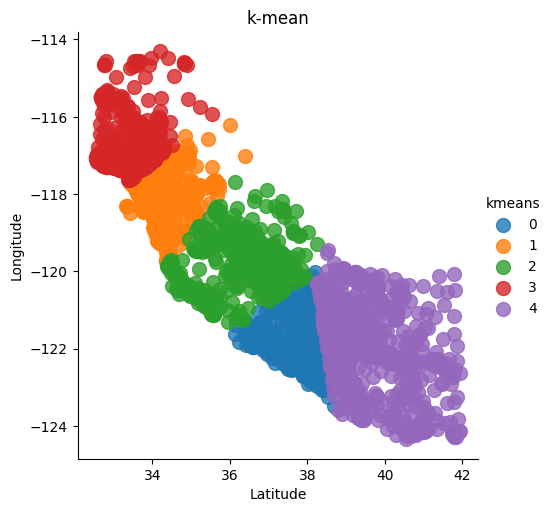

In [162]:
sns.lmplot( x='Latitude' , y='Longitude', data=df, fit_reg=False, scatter_kws={"s":100},hue="kmeans" )
plt.title('k-mean')

잘 나뉘어 있긴한데 .. y 타켓 별로 지도 시각화 하였을 때는 이런식이 아니었음

In [172]:
abs(df.corr()["MedHouseVal"]).sort_values() #그래도 다른 변수들보다는 상관관계 높은듯

Population     0.021205
Longitude      0.045967
AveBedrms      0.079268
HouseAge       0.105623
Latitude       0.144160
room           0.158285
AveRooms       0.241034
AveOccup       0.247044
kmeans         0.348844
MedInc         0.688075
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64

# Feature Selection

In [179]:
#feature selection을 수행할만큼 변수가 많은 것은 아니지만, 상관 계수 0.1 이하 변수는 제거 + 위도 경도 데이터 제거
abs(df.corr()["MedHouseVal"])>0.1

MedInc          True
HouseAge        True
AveRooms        True
AveBedrms      False
Population     False
AveOccup        True
Latitude        True
Longitude      False
MedHouseVal     True
room            True
kmeans          True
Name: MedHouseVal, dtype: bool

In [181]:
df_pre =df.drop(['AveBedrms', 'Population', 'Latitude', 'Longitude'], axis= 1)

In [182]:
X= df_pre.drop(["MedHouseVal"], axis= 1)
y = df_pre[["MedHouseVal"]]

# Modeling

In [189]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 42)

In [190]:
print(X_train.shape)
print(X_test.shape)

(16512, 6)
(4128, 6)


In [191]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [192]:
#모델 정의
lasso = Lasso()
ridge = Ridge()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
lgbm = LGBMRegressor()
catboost = CatBoostRegressor()

In [193]:
estimators = [('La', lasso), ('Rid', ridge), ('RF', rf), ("DT", dt), ("lgbm",lgbm), ('catboost', catboost)]

In [194]:
# 학습
stacking = StackingRegressor(estimators = estimators)
stacking.fit(X_train, y_train)
y_pred_stacking= stacking.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:957: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 0.9766795	total: 18.3ms	remaining: 3.64s
5:	learn: 0.9500268	total: 21.8ms	remaining: 3.62s
6:	learn: 0.9249943	total: 25.2ms	remaining: 3.58s
7:	learn: 0.9021673	total: 33.7ms	remaining: 4.18s
8:	learn: 0.8804499	total: 38.3ms	remaining: 4.22s
9:	learn: 0.8609193	total: 41.8ms	remaining: 4.14s
10:	learn: 0.8428171	total: 45.2ms	remaining: 4.06s
11:	learn: 0.8264502	total: 48.7ms	remaining: 4.01s
12:	learn: 0.8103314	total: 52.3ms	remaining: 3.97s
13:	learn: 0.7961495	total: 56ms	remaining: 3.94s
14:	learn: 0.7827924	total: 62.1ms	remaining: 4.08s
15:	learn: 0.7710074	total: 65.5ms	remaining: 4.03s
16:	learn: 0.7599866	total: 68.8ms	remaining: 3.98s
17:	learn: 0.7495418	total: 72ms	remaining: 3.93s
18:	learn: 0.7400414	total: 75.4ms	remaining: 3.89s
19:	learn: 0.7313022	total: 78.8ms	remaining: 3.86s
20:	learn: 0.7236204	total: 82ms	remaining: 3.82s
21:	learn: 0.7159335	total: 85.4ms	remaining: 3.8s
22:	learn: 0.7093513	total: 88.8ms	remain

In [195]:
from sklearn.metrics import mean_squared_error as mse
np.sqrt(mse(y_pred_stacking, y_test))

0.6182532578420924

In [197]:
from sklearn.metrics import r2_score
r2_score(y_pred_stacking, y_test)

0.5906458915430568

In [199]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 1, 2, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

rf_cv = RandomizedSearchCV(rf, params, n_iter = 10, random_state = 42)
rf_cv = rf_cv.fit(X_train, y_train)
y_rf_cv = rf_cv.predict(X_test)

print(rf_cv.best_params_)  # 교차검증으로 구한 최적의 하이퍼파라미터들
print(np.sqrt(mse(y_test, y_rf_cv)))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
0.6407293078700388


In [201]:
r2_score(y_test, y_rf_cv)

0.6867130393789562

In [202]:
np.sqrt(mse(y_test, y_rf_cv))

0.6407293078700388

역시 튜닝은 해야하네/ 근데 feature engineering 하니까 성능 왜 이럼????